# Grid setup LUT

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
from collections import defaultdict
import csv
import pickle 

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

## Functions

In [2]:
def _create_correspondence(y: int, x: int, angle: int, magnitude: float, n: int):
    """
    Create a correspondence for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    
    Returns:
    np.ndarray: The moving point.
    np.ndarray: The fixed point.
    """
    angle = np.radians(angle)
    mpoint = np.array([0, y, x])
    fpoint_y = y + np.sin(angle) * magnitude
    fpoint_x = x + np.cos(angle) * magnitude
    fpoint = np.array([0, fpoint_y, fpoint_x])
    # Check bounds
    if fpoint_y < 0 or fpoint_x < 0 or fpoint_y > n - 1 or fpoint_x > n - 1:
        raise Exception(f"Invalid correspondence, out of bounds: {mpoint} -> {fpoint}")
    return mpoint, fpoint


def create_case(y: int, x: int, angle: int, magnitude: float, base_mpoints: np.ndarray, base_fpoints: np.ndarray, n: int=7, pad=True):
    """
    Create a case for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    base_mpoints (np.ndarray): The base moving points.
    base_fpoints (np.ndarray): The base fixed points.
    n (int): The size of the grid.
    
    Returns:
    np.ndarray: The deformation field.
    np.ndarray: The Jacobian determinant field.
    """
    #new_size = 15  # 15 x 15
    #pad_size = (new_size - n) // 2
    #fixed_resolution = np.zeros((1, new_size, new_size))
    fixed_resolution = np.zeros((1, n, n))
    # Create the correspondence and apply as the second correspondence in the grid
    mpoint, fpoint = _create_correspondence(y, x, angle, magnitude, n)
    #mpoint += np.array([0, pad_size, pad_size])
    #fpoint += np.array([0, pad_size, pad_size])
    curr_mpoints = base_mpoints.copy()
    curr_fpoints = base_fpoints.copy()
    curr_mpoints = np.append(curr_mpoints, [mpoint], axis=0)
    curr_fpoints = np.append(curr_fpoints, [fpoint], axis=0)
    # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
    #deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_fpoints, curr_mpoints)
    # Crop deformation field to original size
    #deformation = deformation[:, :, pad_size:pad_size + n, pad_size:pad_size + n]
    jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
    return deformation, jdet_field


def show_data(data: dict, y: int, x: int, angle: int, magnitude: float, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    data (dict): The data dictionary.
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector.
    magnitude (float): The magnitude of the vector.
    deformation (np.ndarray): The deformation field.
    title (str): The title of the plot.
    fontsize (int): The fontsize of the text.
    """
    deformation, jdet_field = data[y][x][angle][magnitude]
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    angle_rad = np.radians(angle)
    plt.arrow(jdet_field.shape[1] // 2, jdet_field.shape[0] // 2, np.cos(0) * 1, np.sin(0) * 1, head_width=0.15, head_length=0.15, fc='green', ec='green')
    plt.arrow(x, y, np.cos(angle_rad) * magnitude, np.sin(angle_rad) * magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Draw a dot at moving points
    #for i in range(len(mpoints)):
    #    plt.scatter(mpoints[i][2], mpoints[i][1], color='green')
    
    # Plot the coordinate text
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            # Get the pixel information
            normalized_y = j - (jdet_field.shape[0] // 2) 
            normalized_x = i - (jdet_field.shape[1] // 2)
            
            curr_displacement = deformation[:, 0, j, i]
            displacement_y = curr_displacement[1]
            displacement_x = curr_displacement[2]

            # Get the angle information
            curr_theta_rad = np.arctan2(displacement_y, displacement_x)
            if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
                curr_theta_rad += 2 * np.pi
            curr_theta = np.abs(np.degrees(curr_theta_rad))
            
            # Get the magnitude information
            curr_magnitude = np.linalg.norm(curr_displacement)
            jdet = jdet_field[j, i]
            
            # Setup text to display
            coord_text = f"({displacement_y:.1f}, {displacement_x:.1f})\n"
            jdet_text = f"{jdet:.2f} J"
            vector_text = f"\n{curr_theta:.2f}°\n" + f"∥{curr_magnitude:.2f}∥"
            #pixel_text = coord_text + jdet_text + vector_text
            pixel_text = jdet_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
            
            # Draw the vector direction
            magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
            #plt.arrow(i, j, np.cos(curr_theta_rad) * magnitude_scale, np.sin(curr_theta_rad) * magnitude_scale, head_width=0.15, head_length=0.15, fc='black', ec='black')            

            

    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2) - 1, jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2) - 1, jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)

### Flip case 2

In [11]:

def _create_correspondence2(y: int, x: int, angle: int, magnitude: float, n: int):
    """
    Create a correspondence for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    
    Returns:
    np.ndarray: The moving point.
    np.ndarray: The fixed point.
    """
    angle = np.radians(angle)
    mpoint = np.array([0, y, x])
    fpoint_y = y + np.sin(angle) * magnitude
    fpoint_x = x + np.cos(angle) * magnitude
    fpoint = np.array([0, fpoint_y, fpoint_x])
    return mpoint, fpoint


def create_case2(y: int, x: int, angle: int, magnitude: float, base_mpoints: np.ndarray, base_fpoints: np.ndarray, n: int=7, pad=True, base_magnitude=1, x_1_case=False):
    """
    Create a case for the given parameters.
    
    Parameters:
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector (degrees).
    magnitude (float): The magnitude of the vector.
    base_mpoints (np.ndarray): The base moving points.
    base_fpoints (np.ndarray): The base fixed points.
    n (int): The size of the grid.
    
    Returns:
    np.ndarray: The deformation field.
    np.ndarray: The Jacobian determinant field.
    """
    #new_size = 15  # 15 x 15
    #pad_size = (new_size - n) // 2
    #fixed_resolution = np.zeros((1, new_size, new_size))
    fixed_resolution = np.zeros((1, n, n))
    # Create the correspondence and apply as the second correspondence in the grid
    mpoint, fpoint = _create_correspondence2(y, x, angle, magnitude, n)
    #mpoint += np.array([0, pad_size, pad_size])
    #fpoint += np.array([0, pad_size, pad_size])
    #base_fpoints = np.array([[0, n // 2, n // 2 + 1]])  # normal case
    #base_mpoints = np.array([[0, n // 2, n // 2]])
    
    #x_1_case = False
    if x_1_case:
        if base_fpoints is None:
            base_fpoints = np.array([[0, n // 2, n // 2 + base_magnitude - 1]])  # x - 1 case
        if base_mpoints is None:
            #base_mpoints = np.array([[0, n // 2, n // 2 - base_magnitude]])
            base_mpoints = np.array([[0, n // 2, n // 2 - 1]])
    else:  # else normal case
        if base_fpoints is None:
            base_fpoints = np.array([[0, n // 2, n // 2 + base_magnitude]])
        if base_mpoints is None:
            base_mpoints = np.array([[0, n // 2, n // 2]])
        
        
    curr_mpoints = base_mpoints.copy()
    curr_fpoints = base_fpoints.copy()
    curr_mpoints = np.append(curr_mpoints, [mpoint], axis=0)
    curr_fpoints = np.append(curr_fpoints, [fpoint], axis=0)
    # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
    #deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
    deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_fpoints, curr_mpoints)
    # Crop deformation field to original size
    #deformation = deformation[:, :, pad_size:pad_size + n, pad_size:pad_size + n]
    jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
    return deformation, jdet_field


def show_data2(deformation, jdet_field, y: int, x: int, angle: int, magnitude: float, title="", fontsize=8, base_magnitude=1, figsize=(10, 5)):
    """
    Show the grid of deformation information.
    
    Parameters:
    data (dict): The data dictionary.
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector.
    magnitude (float): The magnitude of the vector.
    deformation (np.ndarray): The deformation field.
    title (str): The title of the plot.
    fontsize (int): The fontsize of the text.
    """
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=figsize)
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    angle_rad = np.radians(angle)
    
    # Draw arrow for center
    plt.arrow(jdet_field.shape[1] // 2, jdet_field.shape[0] // 2, np.cos(0) * base_magnitude, np.sin(0) * base_magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Draw arrow for second neighbor
    plt.arrow(x, y, np.cos(angle_rad) * magnitude, np.sin(angle_rad) * magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Draw a dot at moving points
    #for i in range(len(mpoints)):
    #    plt.scatter(mpoints[i][2], mpoints[i][1], color='green')
    
    # Plot the coordinate text
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            # Get the pixel information
            normalized_y = j - (jdet_field.shape[0] // 2) 
            normalized_x = i - (jdet_field.shape[1] // 2)
            
            curr_displacement = deformation[:, 0, j, i]
            displacement_y = curr_displacement[1]
            displacement_x = curr_displacement[2]

            # Get the angle information
            curr_theta_rad = np.arctan2(displacement_y, displacement_x)
            if curr_theta_rad < 0:  # Ensure the angle is in the range [0, 2pi)
                curr_theta_rad += 2 * np.pi
            curr_theta = np.abs(np.degrees(curr_theta_rad))
            
            # Get the magnitude information
            curr_magnitude = np.linalg.norm(curr_displacement)
            jdet = jdet_field[j, i]
            
            # Setup text to display
            coord_text = f"({displacement_y:.1f}, {displacement_x:.1f})\n"
            jdet_text = f"{jdet:.2f} J"
            vector_text = f"\n{curr_theta:.2f}°\n" + f"∥{curr_magnitude:.2f}∥"
            #pixel_text = coord_text + jdet_text + vector_text
            pixel_text = coord_text + jdet_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
            
            if normalized_y % base_magnitude == 0 and normalized_x % base_magnitude == 0 and base_magnitude > 1:
                # Draw a dot
                plt.scatter(i, j, color='green')
            
            # Draw the vector direction
            magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
            #plt.arrow(i, j, np.cos(curr_theta_rad) * magnitude_scale, np.sin(curr_theta_rad) * magnitude_scale, head_width=0.15, head_length=0.15, fc='black', ec='black')            

            

    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2) - 1, jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2) - 1, jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)
    
    
def show_jdet_only(jdet_field, title="", fontsize=8, base_magnitude=1, figsize=(10, 5)):
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=figsize)
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            jdet = jdet_field[j, i]
            
            # Setup text to display
            jdet_text = f"{jdet:.2f} J"
            pixel_text = jdet_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='normal')
            
    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2) - 1, jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2) - 1, jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)


## Normal cases

Central Jacobian determinant: 0.8770763994718028


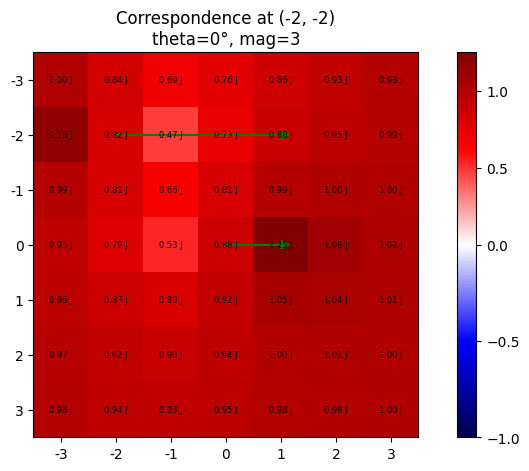

In [115]:
# Neighboring correspondence parameters
oy, ox = (-2, -2)
angle = 0
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 0.8770763994718023


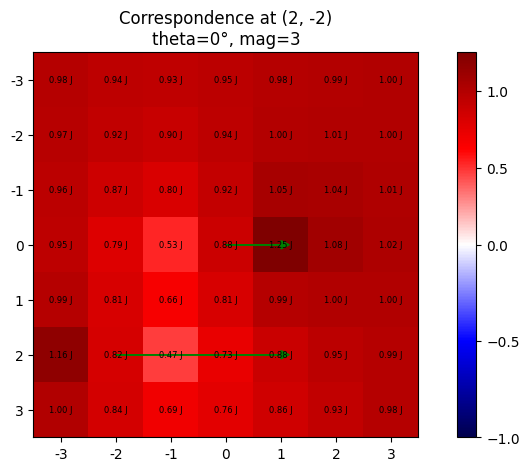

In [116]:
# Neighboring correspondence parameters
oy, ox = (2, -2)
angle = 0
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 0.754276472984532


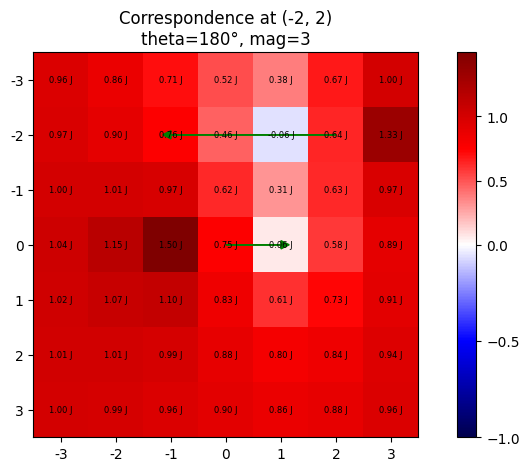

In [117]:
# Neighboring correspondence parameters
oy, ox = (-2, 2)
angle = 180
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 0.7542764729845308


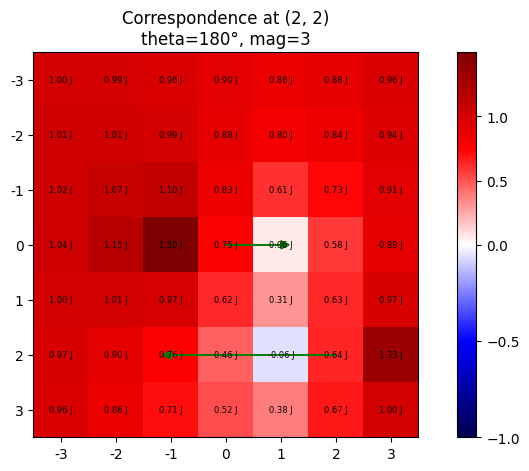

In [118]:
# Neighboring correspondence parameters
oy, ox = (2, 2)
angle = 180
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 0.8512714886957976


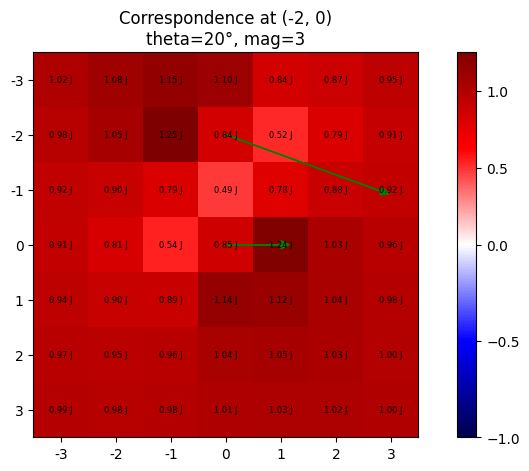

In [119]:
# Neighboring correspondence parameters
oy, ox = (-2, 0)
angle = 20
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 0.8512714886957987


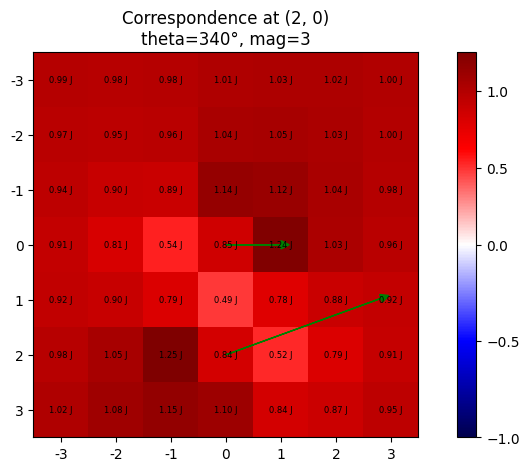

In [120]:
# Neighboring correspondence parameters
oy, ox = (2, 0)
angle = 340
magnitude = 3
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 1.0991523408694681


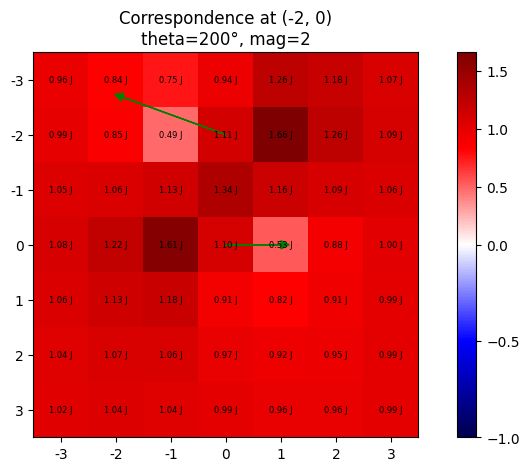

In [121]:
# Neighboring correspondence parameters
oy, ox = (-2, 0)
angle = 200
magnitude = 2
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

Central Jacobian determinant: 1.0991523408694674


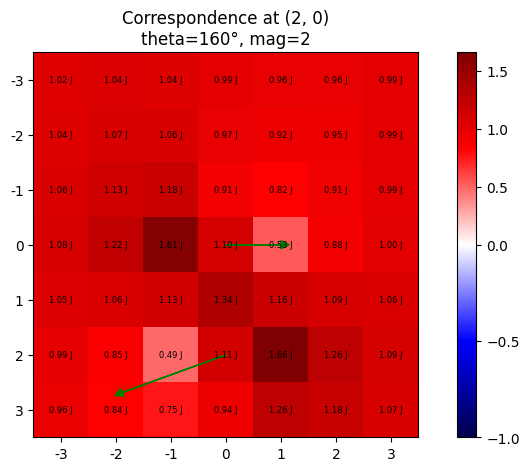

In [123]:
# Neighboring correspondence parameters
oy, ox = (2, 0)
angle = 160
magnitude = 2
base_magnitude=1
x_1_case = False
n = 7

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
        title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
        fontsize=6, figsize=(10, 5),
        base_magnitude=base_magnitude)

## x3 magnitude test cases

In [8]:
from skimage.measure import block_reduce
from scipy.ndimage import uniform_filter


def run_case(oy, ox, angle, magnitude, n=7, x_1_case = False, multiplier=3, base_magnitude=1): 
    #############################################
    # Case 2: base x

    # Run the case
    y = oy + n // 2  # Get central coordinates
    x = ox + n // 2
    deformation, jdet_field_original = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=x_1_case)
    central_jdet = jdet_field_original[n//2, n//2]

    print("Central Jacobian determinant:", central_jdet)
    show_data2(deformation, jdet_field_original, y, x, angle, magnitude, 
               title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
               fontsize=6, figsize=(10, 5),
               base_magnitude=base_magnitude)

    #############################################
    # Case 2: base x bigger

    # Base correspondence parameters
    base_magnitude = base_magnitude * multiplier

    # Neighboring correspondence parameters
    y, x = (oy * multiplier, ox * multiplier)
    angle = angle
    magnitude = magnitude * multiplier

    # Setup the new grid size
    n = n * multiplier

    # Run the case
    y = y + n // 2  # Get central coordinates
    x = x + n // 2
    deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=n, base_magnitude=base_magnitude, x_1_case=x_1_case)
    central_jdet = jdet_field[n//2, n//2]
    
    #mean_field = uniform_filter(jdet_field, size=3)
    #print("Mean field")
    #pprint(mean_field)
    #print(mean_field.max())
    
    # Downsample jdet_field and show it.
    jdet_downsampled = block_reduce(jdet_field, block_size=(3, 3), func=np.mean)
    
    jdet_original_corr = jdet_field_original.flatten()
    #jdet_original_corr = (jdet_original_corr - jdet_original_corr.mean()) / jdet_original_corr.std()
    jdet_downsampled_corr = jdet_downsampled.flatten()
    #jdet_downsampled_corr = (jdet_downsampled_corr - jdet_downsampled_corr.mean()) / jdet_downsampled_corr.std()
    correlation = np.corrcoef(jdet_original_corr, jdet_downsampled_corr)[0, 1]

    # Plot the grid of Jacobian determinants color values
    show_jdet_only(jdet_downsampled, title=f"Correspondence at ({y - n // 2}, {x - n // 2}) (downscaled)\ntheta={angle}°, mag={magnitude}", 
                fontsize=6, figsize=(10, 5))
    
    
    
    show_data2(deformation, jdet_field, y, x, angle, magnitude, 
            title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
            fontsize=6, figsize=(15, 10),
            base_magnitude=base_magnitude)
    
    
    print("Correlation:", correlation)
    print("Central Jacobian determinant:", central_jdet)
    
    #############################################
    return jdet_field_original, jdet_downsampled
    

In [9]:
USE_X_1_CASE = False
MULTIPLIER = 3
base_magnitude = 1
n = 7  # Setup the grid size

Central Jacobian determinant: 0.8031487554435848


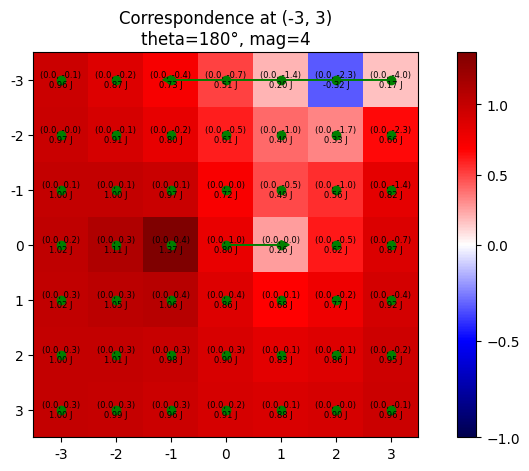

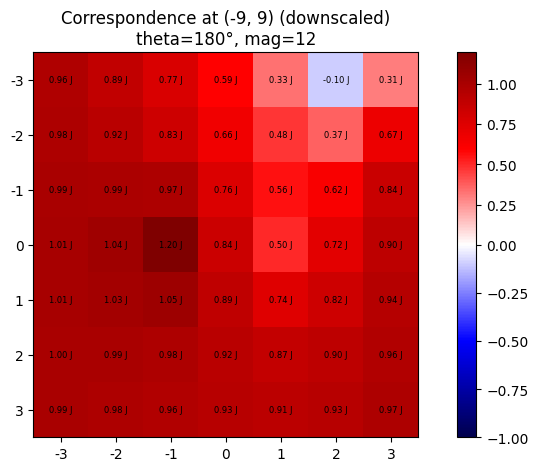

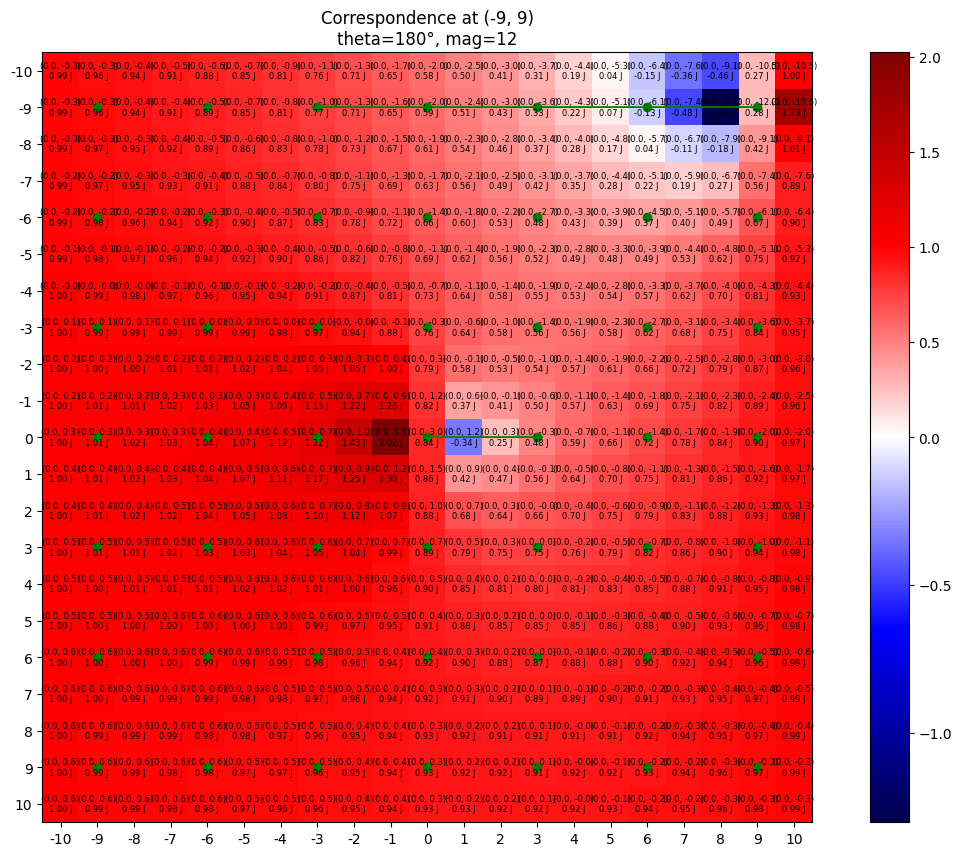

Correlation: 0.9934294352265418
Central Jacobian determinant: 0.8385092068393244


In [10]:
# Neighboring correspondence parameters
oy, ox = (-3, 3)
angle = 180
magnitude = 4

_, _ = run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.938601783658949


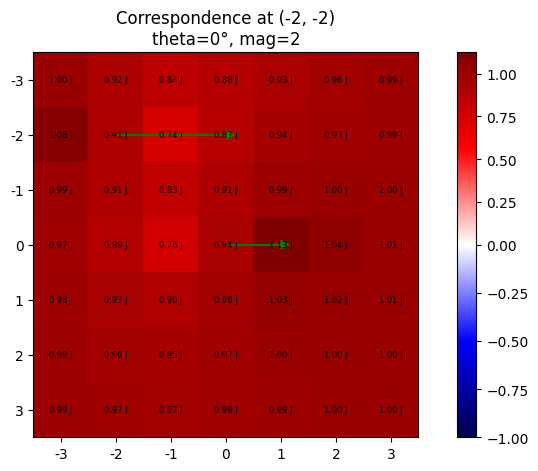

Central Jacobian determinant: 0.9501383802097949


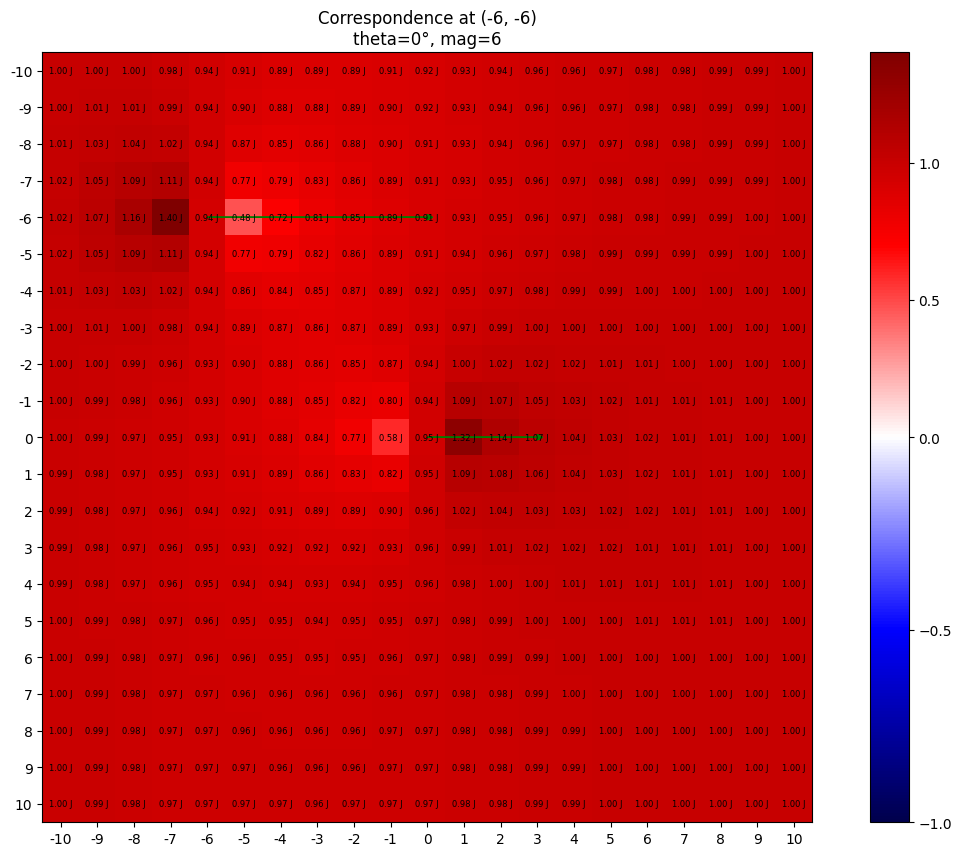

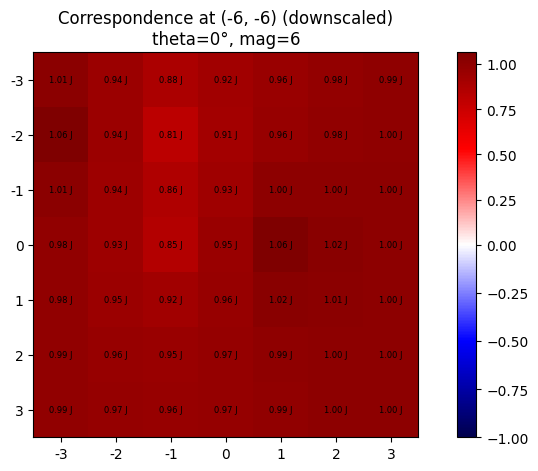

In [101]:
# Neighboring correspondence parameters
oy, ox = (-2, -2)
angle = 0
magnitude = 2

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.9381143261376081


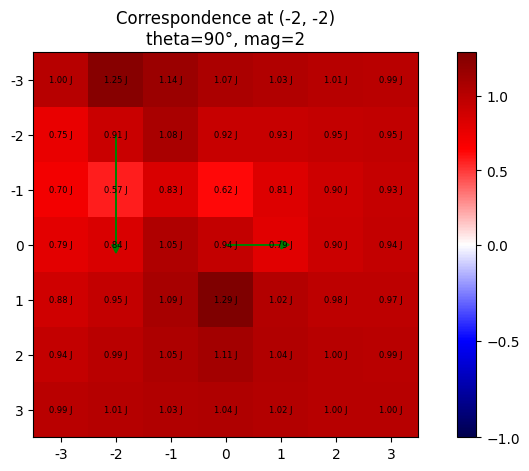

Central Jacobian determinant: 0.9400652749507911


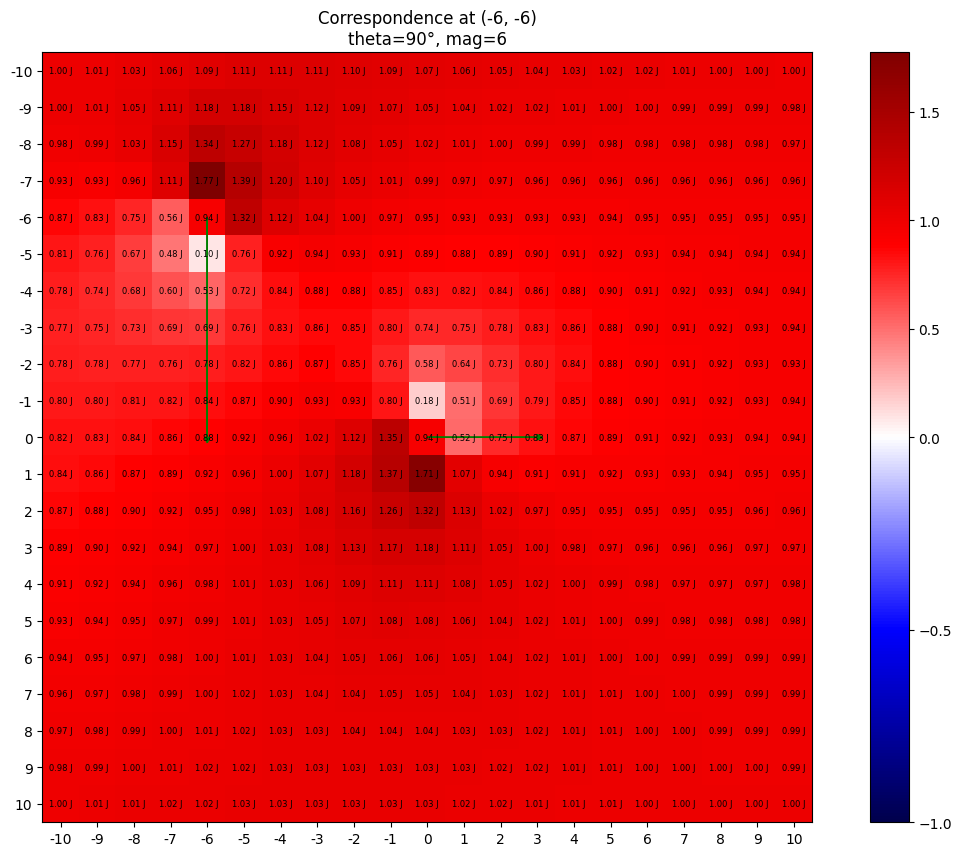

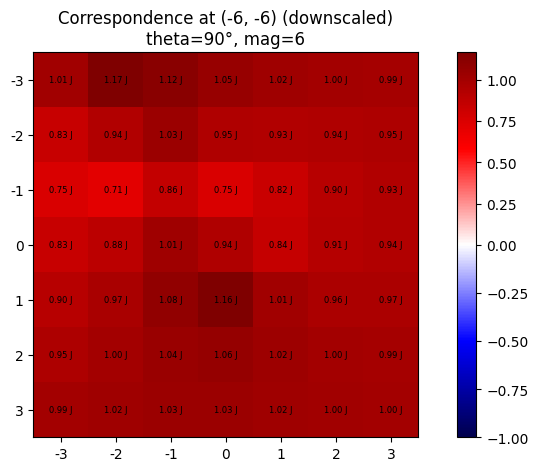

In [105]:
# Neighboring correspondence parameters
oy, ox = (-2, -2)
angle = 90
magnitude = 2

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.8162653425023563


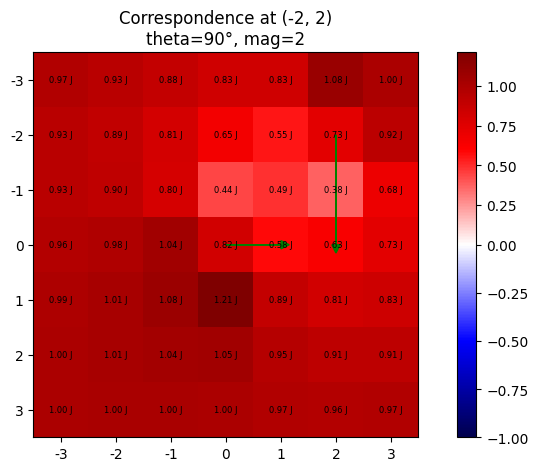

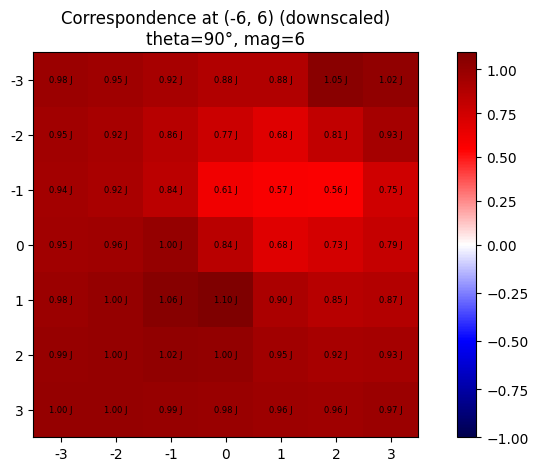

Central Jacobian determinant: 0.8433746515328122


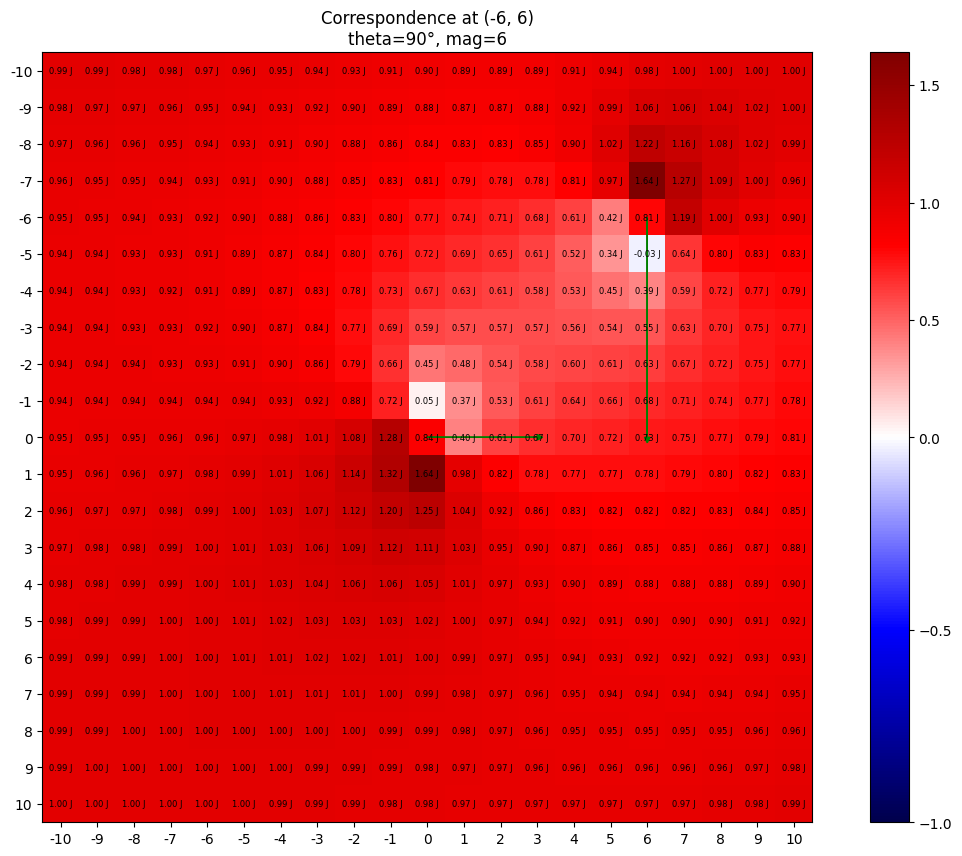

In [108]:
# Neighboring correspondence parameters
oy, ox = (-2, 2)
angle = 90
magnitude = 2

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.8878189414893449


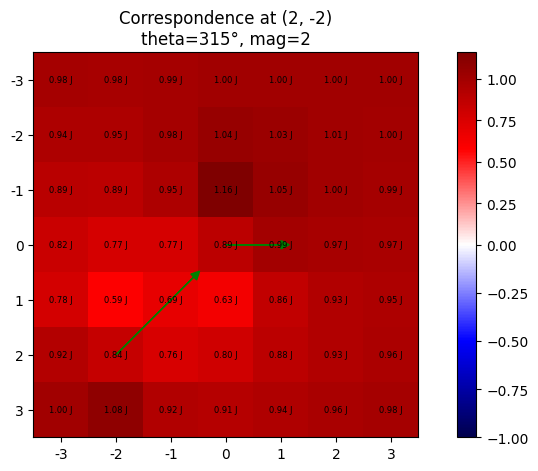

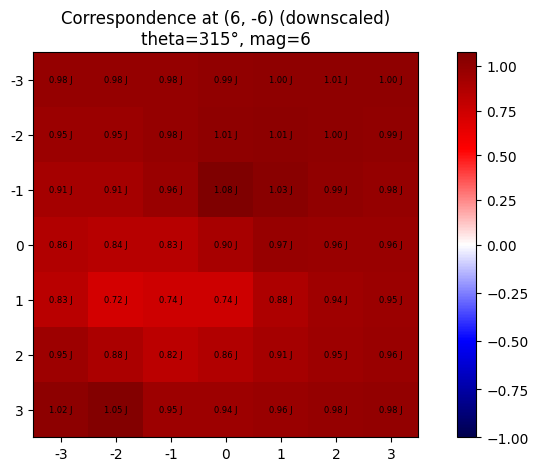

Central Jacobian determinant: 0.9036386930816327


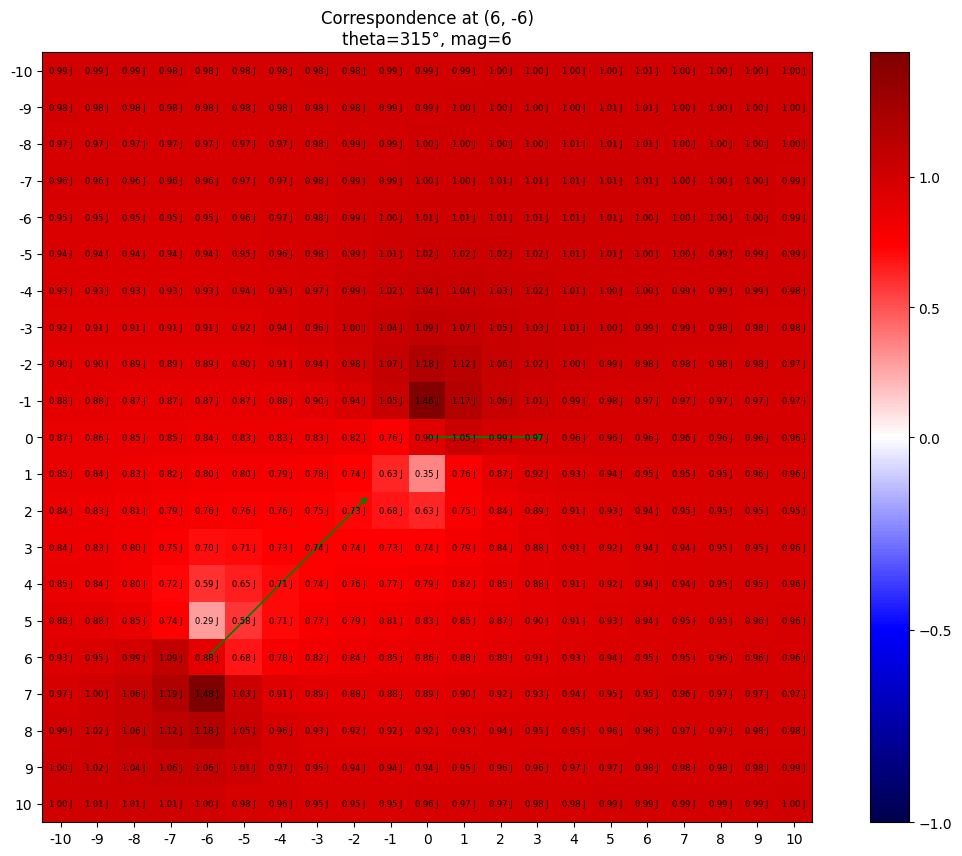

In [110]:
# Neighboring correspondence parameters
oy, ox = (2, -2)
angle = 315
magnitude = 2

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.8487175450437766


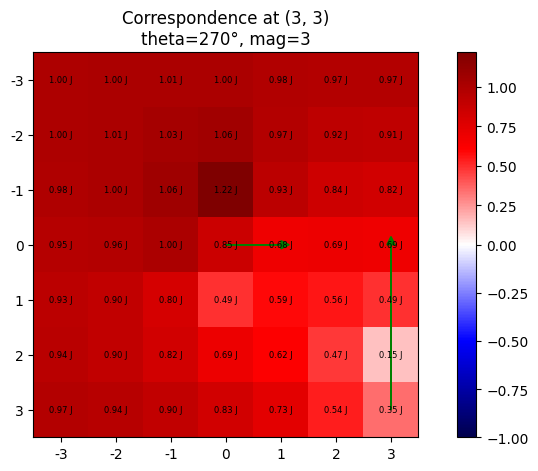

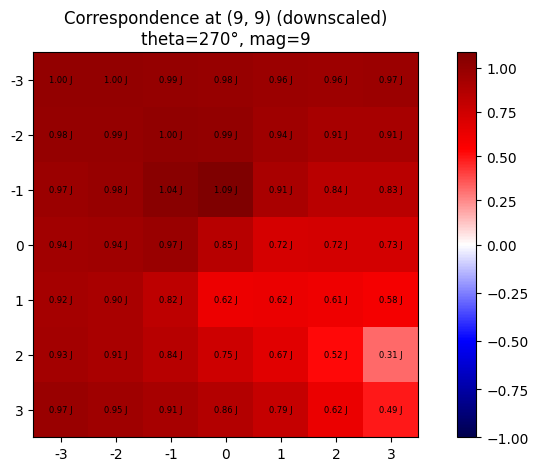

Central Jacobian determinant: 0.8459552427747368


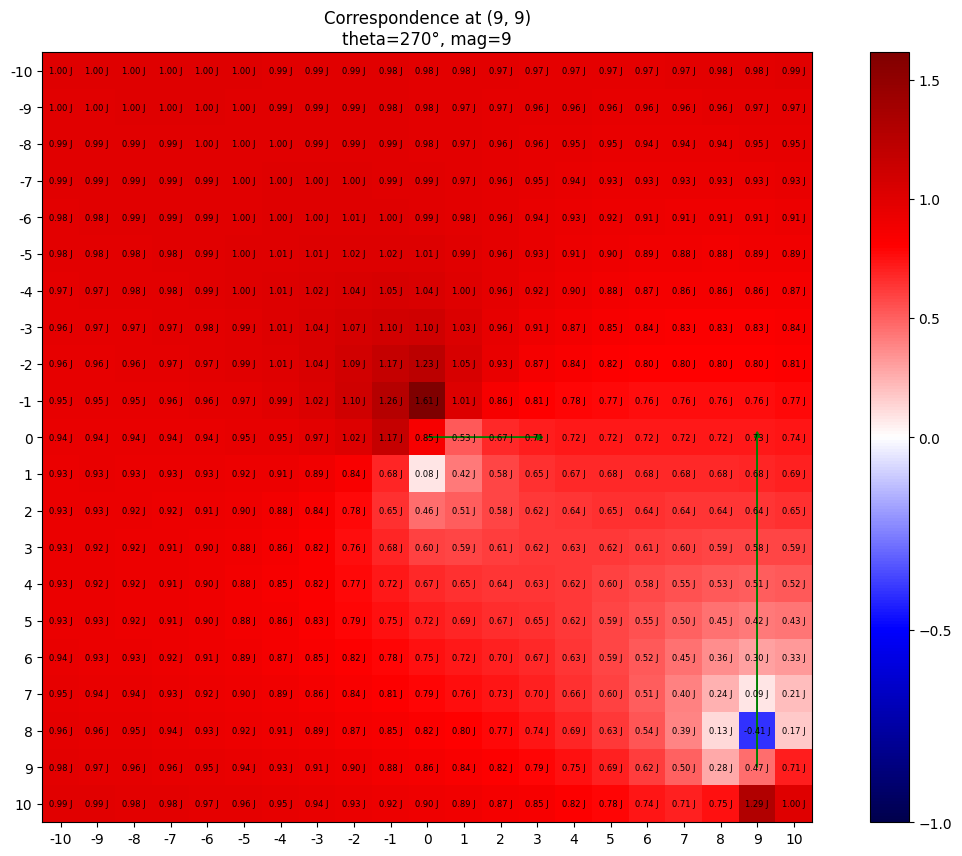

In [111]:
# Neighboring correspondence parameters
oy, ox = (3, 3)
angle = 270
magnitude = 3

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 1.447759531518034


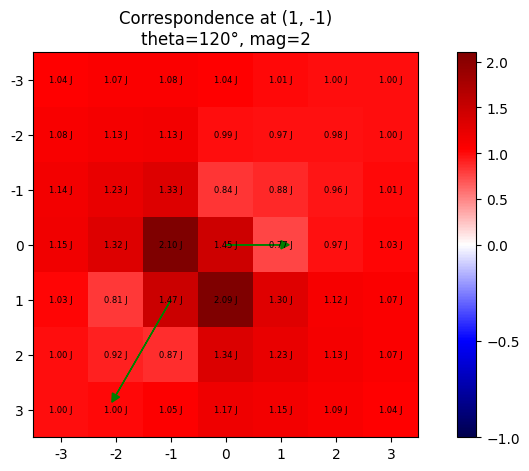

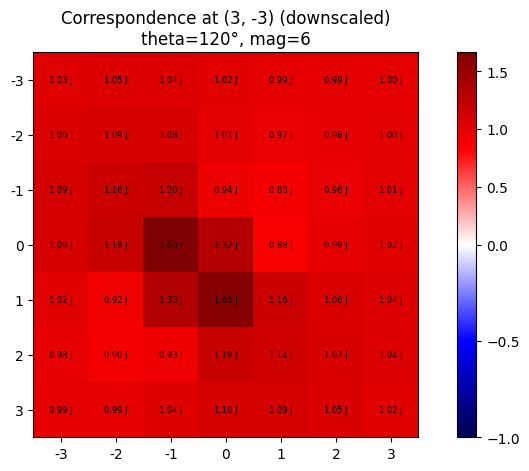

Central Jacobian determinant: 1.321535160230732


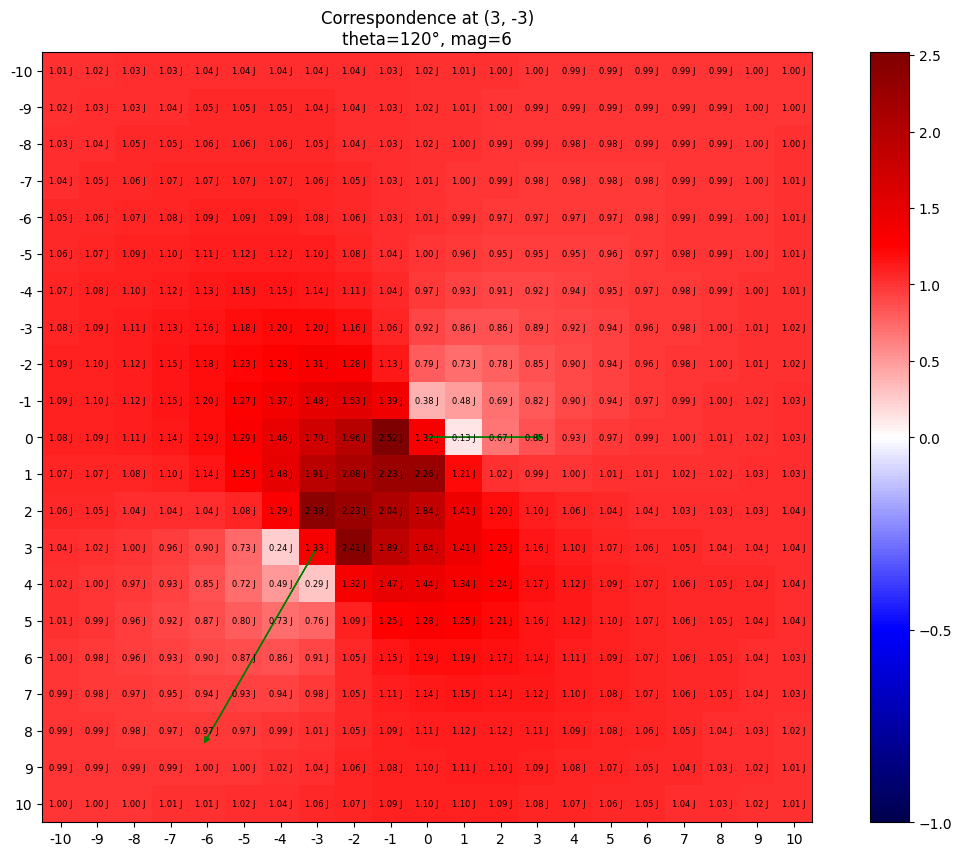

In [114]:
# Neighboring correspondence parameters
oy, ox = (1, -1)
angle = 120
magnitude = 2

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

Central Jacobian determinant: 0.8246638700000957


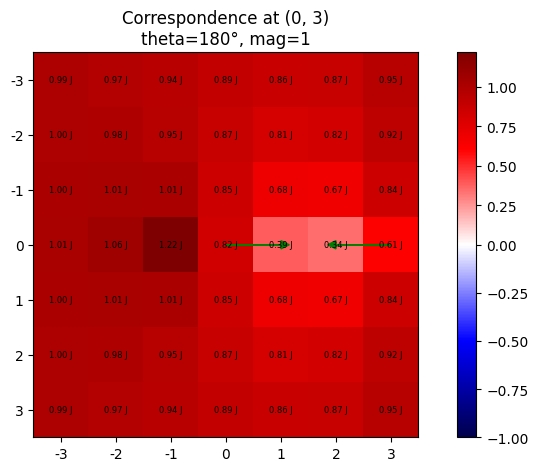

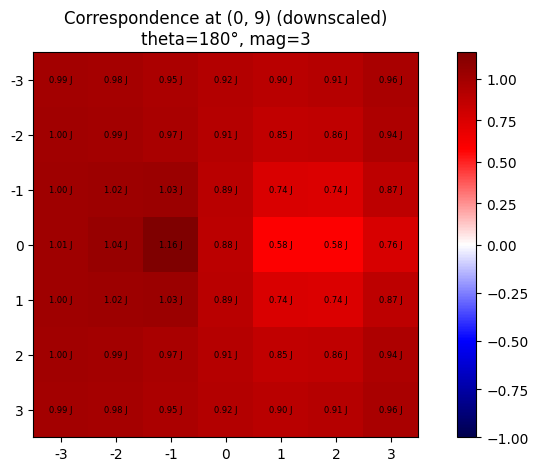

Central Jacobian determinant: 0.8829609844076255


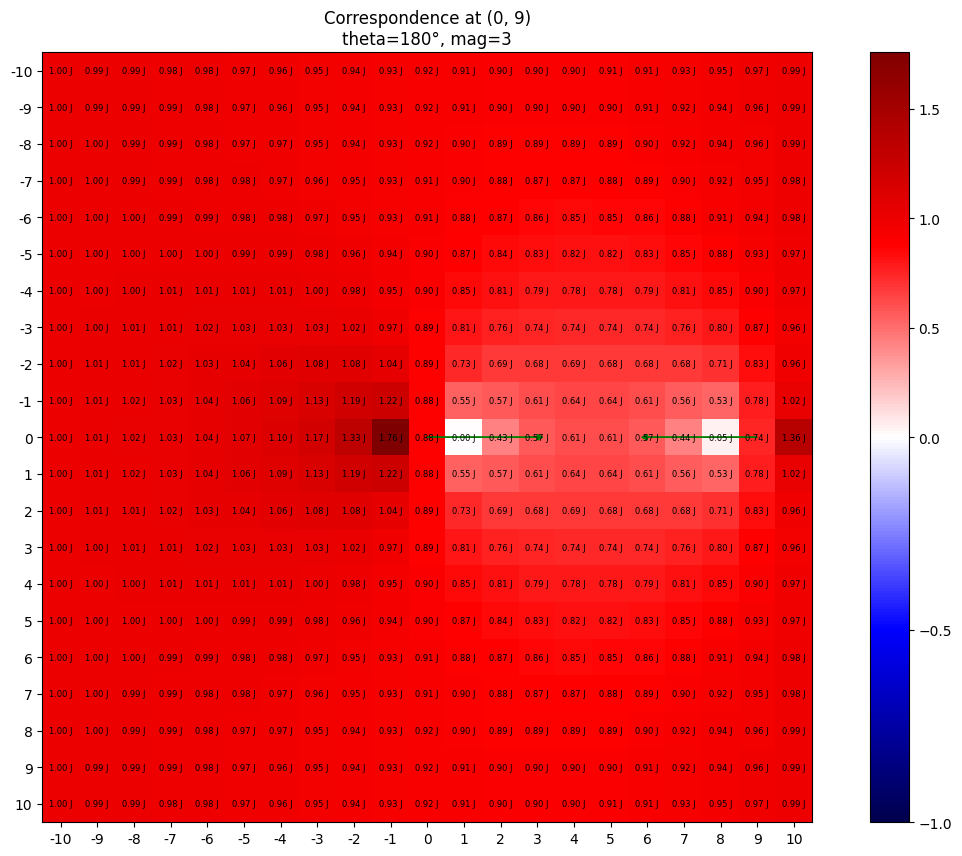

In [126]:
# Neighboring correspondence parameters
oy, ox = (0, 3)
angle = 180
magnitude = 1

run_case(oy, ox, angle, magnitude, n=n, x_1_case=USE_X_1_CASE, multiplier=MULTIPLIER)

## END

Central Jacobian determinant: 0.8031487554435848


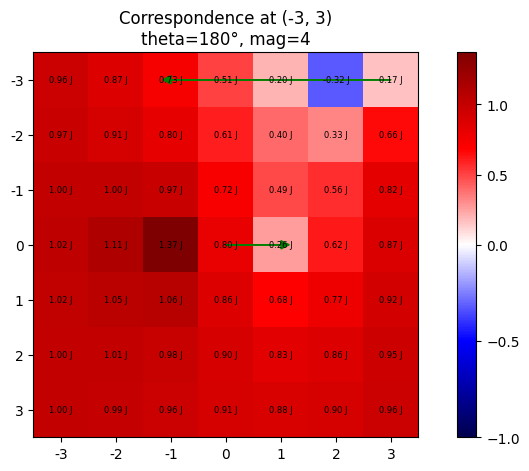

Central Jacobian determinant: 0.8385092068393244


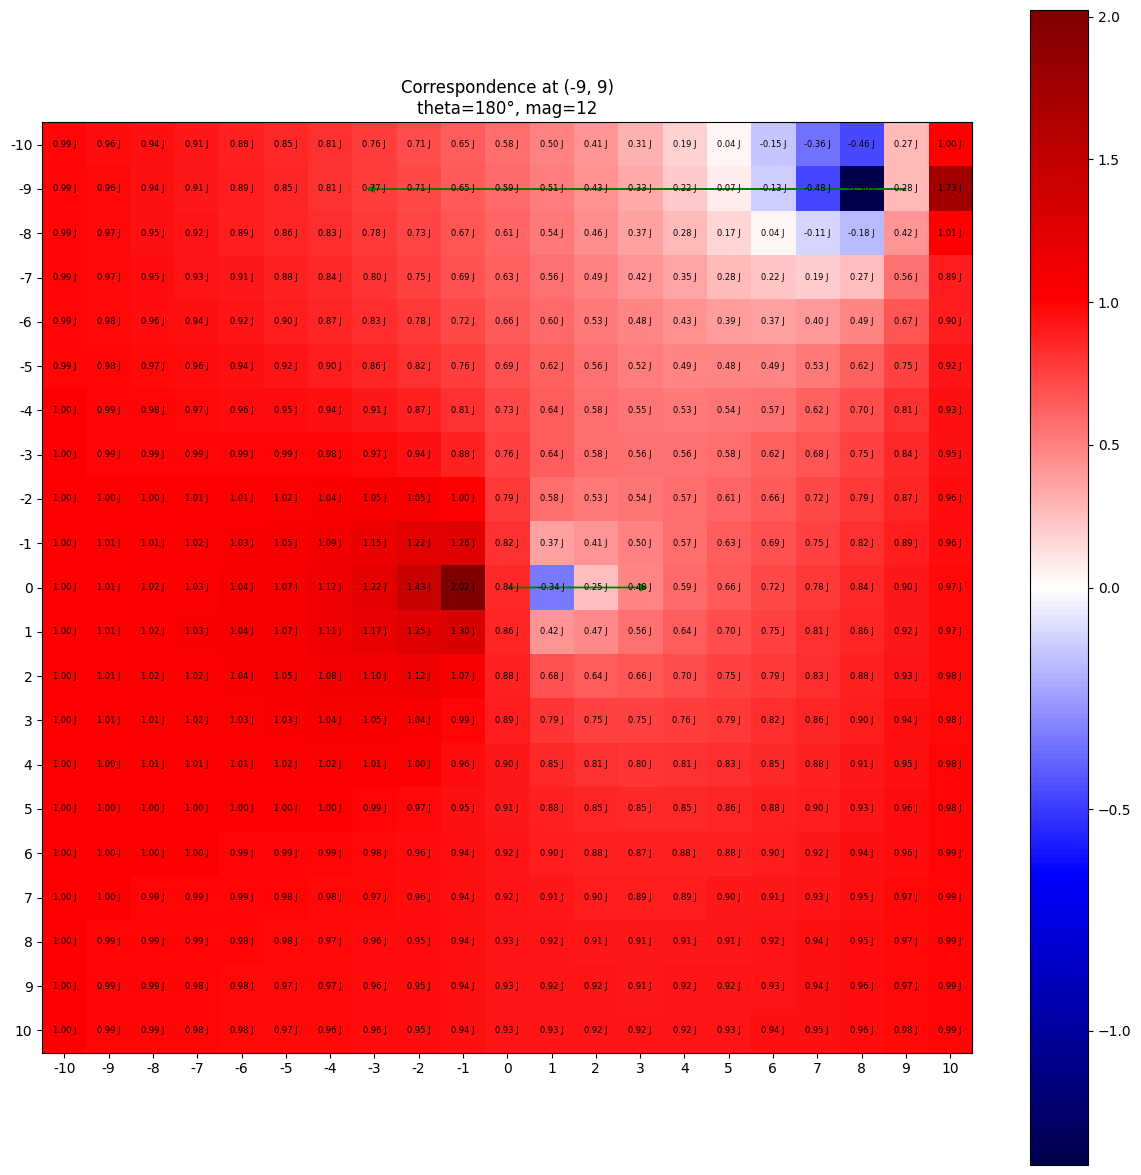

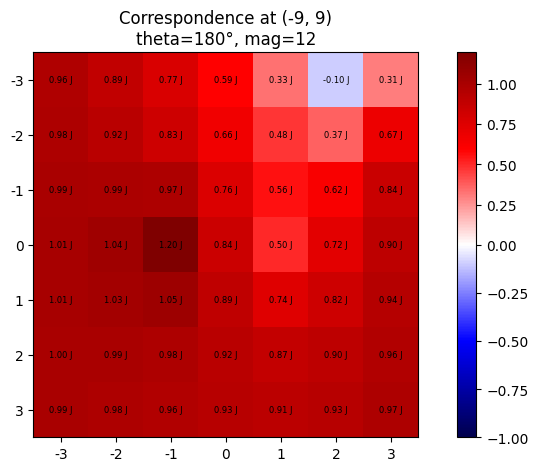

In [79]:

USE_X_1_CASE = False
MULTIPLIER = 3


# Base correspondence parameters
base_magnitude = 1

# Neighboring correspondence parameters
oy, ox = (-3, 3)
angle = 180
magnitude = 4
n = 7  # Setup the grid size

#############################################
# Case 2: base x

# Run the case
y = oy + n // 2  # Get central coordinates
x = ox + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=7, base_magnitude=base_magnitude, x_1_case=USE_X_1_CASE)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
           title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
           fontsize=6, figsize=(10, 5),
           base_magnitude=base_magnitude)

#############################################
# Case 2: base x bigger

# Base correspondence parameters
base_magnitude = base_magnitude * MULTIPLIER

# Neighboring correspondence parameters
y, x = (oy * MULTIPLIER, ox * MULTIPLIER)
angle = angle
magnitude = magnitude * MULTIPLIER

# Setup the new grid size
n = n * MULTIPLIER

# Run the case
y = y + n // 2  # Get central coordinates
x = x + n // 2
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=n, base_magnitude=base_magnitude, x_1_case=USE_X_1_CASE)
central_jdet = jdet_field[n//2, n//2]

print("Central Jacobian determinant:", central_jdet)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
           title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
           fontsize=6, figsize=(15, 15),
           base_magnitude=base_magnitude)

#############################################
# Downsample jdet_field and show it.
jdet_downsampled = block_reduce(jdet_field, block_size=(3, 3), func=np.mean)

# Plot the grid of Jacobian determinants color values
show_jdet_only(jdet_downsampled, title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", 
               fontsize=6, figsize=(10, 5))

In [4]:
def nested_dict():
    return defaultdict(nested_dict)

## Generate LUT data

In [57]:
# User parameters
n = 7
SAVE_TO_FILE = True
pickle_filepath = 'lut_data_case2_x-1_x3.pkl'

# Setup initial correspondence in the center pixel.
mpoints = np.array([[0, (n // 2), (n // 2)]])
fpoints = np.array([[0, (n // 2), (n // 2) + 1]])
fixed_resolution = np.zeros((1, n, n))

# Define a function to create a nested defaultdict
def nested_dict():
    return defaultdict(nested_dict)
data = nested_dict()

# Create a range of correspondences for each pixel
for y in tqdm(range(n), desc="Outer loop y"):
    for x in tqdm(range(n), desc="Outer loop x", leave=False):
        # Skip the center pixel
        if y == (n // 2) and x == (n // 2):
            continue
        y *= 3
        x *= 3
        # Create correspondences for each angle (degrees) [0, 360) in increments of 10]
        for angle in tqdm(range(0, 360, 10), desc="Inner loop angle", leave=False):
            
            # Create correspondences for each magnitude from [0.5, 5.0] in increments of 0.5
            for magnitude in tqdm(range(1, 11), desc="Innermost loop magnitude", leave=False):
                magnitude /= 2
                magnitude *=3
                # Create the correspondence and apply as the second correspondence in the grid
                try:
                    deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=21, base_magnitude=3, x_1_case=USE_X_1_CASE)
                except Exception as e:
                    #print(f"Error: {e}")
                    #print(f"y: {y}, x: {x}, angle: {angle}, magnitude: {magnitude}")
                    continue
                data[y][x][angle][magnitude] = deformation, jdet_field
                
"""
# Create a range of correspondences for each pixel
for y in range(n):
    for x in range(n):
        # Skip the center pixel
        if y == (n // 2) and x == (n // 2):
            continue
        # Create correspondences for each angle (degrees) [0, 360) in increments of 10]
        for angle in range(0, 360, 10):
            
            # Create correspondences for each magnitude from [0.5, 5.0] in increments of 0.5
            for magnitude in range(1, 11):
                magnitude /= 2
                
                # Create the correspondence and apply as the second correspondence in the grid
                try:
                    deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints)
                except Exception as e:
                    #print(f"Error: {e}")
                    #print(f"y: {y}, x: {x}, angle: {angle}, magnitude: {magnitude}")
                    continue
                data[y][x][angle][magnitude] = deformation, jdet_field
"""

# Pickle the nested dictionary to a file
if SAVE_TO_FILE:
    with open(pickle_filepath, 'wb') as file:
        pickle.dump(data, file)

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

## Save to CSV spreadsheet

In [58]:
# Load the pickled dictionary from the file
with open('lut_data_case2_x-1.pkl', 'rb') as file:
    data = pickle.load(file)

In [59]:
csv_filepath = "lut_data_7x7_case2_x-1_min_jdet.csv"

headers = ["x", "y", "theta", "mag", "J"]
with open(csv_filepath, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    for x in tqdm(range(n), desc="Outer loop x"):
        
        for y in tqdm(range(n), desc="Outer loop y", leave=False):
            if y == (n // 2) and x == (n // 2):
                continue

            for angle in tqdm(range(0, 360, 10), desc="Inner loop angle", leave=False):
                for magnitude in tqdm(range(1, 11), desc="Innermost loop magnitude", leave=False):
                    magnitude /= 2
                    
                    try:
                        deformation_field, jdet_field = data[y][x][angle][magnitude]
                        jdet = np.min(jdet_field)
                        normalized_y = y - (jdet_field.shape[0] // 2)
                        normalized_x = x - (jdet_field.shape[1] // 2)
                        writer.writerow([normalized_x, normalized_y, angle, magnitude, jdet])
                    except Exception as e:
                        continue

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

## Load data and visualize it

In [127]:
# Load the pickled dictionary from the file
with open('lut_data_case2_x-1_x3.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

In [128]:
loaded_data.keys()

dict_keys([])

In [57]:
loaded_data[12][0]

defaultdict(<function __main__.nested_dict()>,
            {0: defaultdict(<function __main__.nested_dict()>,
                         {1.5: (array([[[[0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
                                    [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
                                    [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
                                    ...,
                                    [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
                                    [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
                                    [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ]]],
                           
                           
                                  [[[0.        , 0.        , 0.        , ..., 0.        , 0.    

## Try x3

In [60]:
# Show grid information at a specific index
y, x = (0, 1)
angle = 0
magnitude = 3.0
n = 7

# Scale by 3
y = int((y + n // 2) * 3)
x = int((x + n // 2) * 3)
print(y, x)
#magnitude = magnitude * 3
#n = n * 3
# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

9 12


ValueError: not enough values to unpack (expected 2, got 0)

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0

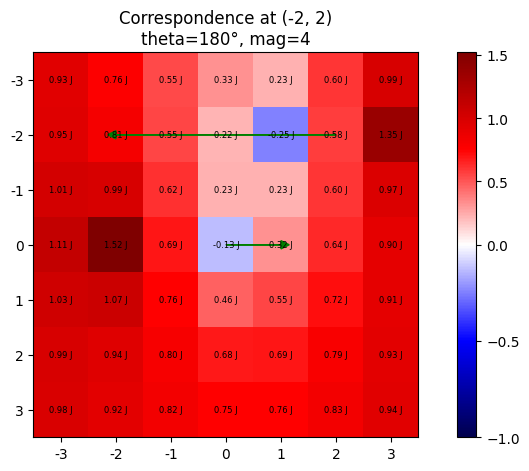

In [62]:
# Show grid information at a specific index
y, x = (-2, 2)
angle = 180
magnitude = 4
n = 7

y = y + n // 2
x = x + n // 2
# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

### Symmetry

array([[[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0

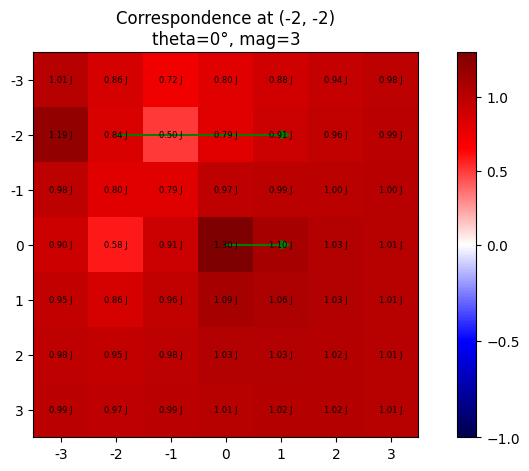

array([[[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0

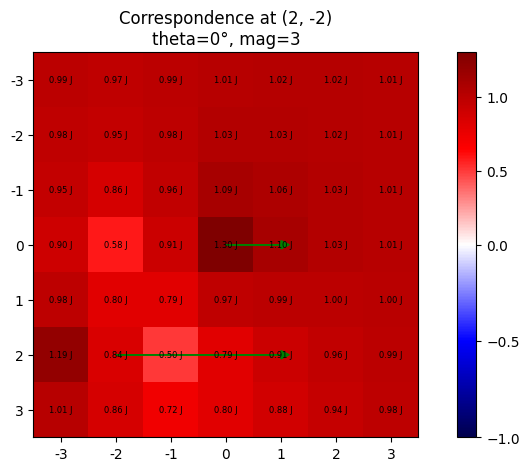

In [63]:
# Show grid information at a specific index
y, x = (1, 1)
angle = 0
magnitude = 3

# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)



# Show grid information at a specific index
y, x = (5, 1)
angle = 0
magnitude = 3

# Get info
deformation, jdet_field = loaded_data[y][x][angle][magnitude]
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
show_data(loaded_data, y, x, angle, magnitude, 
          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)

### Flip mpoints and fpoints in Laplacian and test

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.  

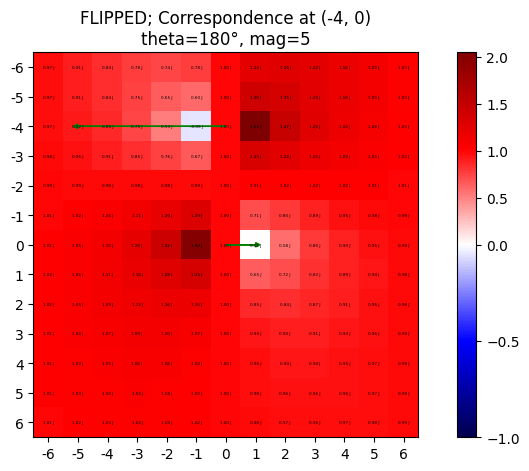

In [64]:
# Show grid information at a specific index
y, x = (2, 6)
angle = 180
magnitude = 5
n = 13

# Get info
deformation, jdet_field = create_case2(y, x, angle, magnitude, None, None, n=n)
central_jdet = jdet_field[n//2, n//2]

deform = deformation[:, 0, :, :]
pprint(deform)
pprint(jdet_field)
#deformation, _ = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

print("Central Jacobian determinant:", central_jdet)
#show_data(loaded_data, y, x, angle, magnitude, 
#          title=f"Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=6)
show_data2(deformation, jdet_field, y, x, angle, magnitude, 
           title=f"FLIPPED; Correspondence at ({y - n // 2}, {x - n // 2})\ntheta={angle}°, mag={magnitude}", fontsize=3)

## Test cases

In [65]:
# Show grid information at a specific index with padding
y, x = (1, 6)
angle = 180
magnitude = 4
deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

pprint(deformation[2, 0, :, :])

array([[ 2.81870257,  2.96058902,  3.08336609,  2.29026198,  1.5437825 ,  1.04923093,  0.7529237 ,  0.57827723,  0.47339033,  0.40913594,  0.37025335,  0.3481525 ,  0.33851401],
       [ 2.67663571,  2.97925156,  3.99963474,  2.24521152,  1.29268857,  0.85183196,  0.6336101 ,  0.51230228,  0.43820138,  0.38997808,  0.35947201,  0.3412812 ,  0.33324121],
       [ 2.23202727,  2.28023193,  2.25935271,  1.39972004,  0.53110357,  0.43341812,  0.42025789,  0.40354535,  0.38091668,  0.35898002,  0.34158526,  0.32984695,  0.32452572],
       [ 1.73919302,  1.65053612,  1.35873841,  0.56422383, -0.99990869, -0.06819073,  0.21407031,  0.30301111,  0.32693321,  0.32814582,  0.32284423,  0.31745364,  0.31471965],
       [ 1.33510055,  1.224659  ,  0.96251883,  0.49906357, -0.03877441,  0.0801456 ,  0.20262877,  0.26936753,  0.29846981,  0.30766129,  0.30881786,  0.30720371,  0.30604012],
       [ 1.04126864,  0.95180055,  0.76924483,  0.50930858,  0.26613916,  0.22528584,  0.24796379,  0.27475839

In [66]:
# Show grid information at a specific index without padding
y, x = (1, 6)
angle = 180
magnitude = 4
deformation, jdet_field = create_case(y, x, angle, magnitude, mpoints, fpoints, n)

pprint(deformation[2, 0, :, :])

array([[ 2.81870257,  2.96058902,  3.08336609,  2.29026198,  1.5437825 ,  1.04923093,  0.7529237 ,  0.57827723,  0.47339033,  0.40913594,  0.37025335,  0.3481525 ,  0.33851401],
       [ 2.67663571,  2.97925156,  3.99963474,  2.24521152,  1.29268857,  0.85183196,  0.6336101 ,  0.51230228,  0.43820138,  0.38997808,  0.35947201,  0.3412812 ,  0.33324121],
       [ 2.23202727,  2.28023193,  2.25935271,  1.39972004,  0.53110357,  0.43341812,  0.42025789,  0.40354535,  0.38091668,  0.35898002,  0.34158526,  0.32984695,  0.32452572],
       [ 1.73919302,  1.65053612,  1.35873841,  0.56422383, -0.99990869, -0.06819073,  0.21407031,  0.30301111,  0.32693321,  0.32814582,  0.32284423,  0.31745364,  0.31471965],
       [ 1.33510055,  1.224659  ,  0.96251883,  0.49906357, -0.03877441,  0.0801456 ,  0.20262877,  0.26936753,  0.29846981,  0.30766129,  0.30881786,  0.30720371,  0.30604012],
       [ 1.04126864,  0.95180055,  0.76924483,  0.50930858,  0.26613916,  0.22528584,  0.24796379,  0.27475839